In [1]:
%load_ext autoreload
%autoreload 2

# add src to sys-path
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('../src')
from matplotlib.pyplot import figure
import subprocess

In [2]:
def convert_and_read_fit_file(filename):
    subprocess.run(["java", "-jar", "FitSDKRelease_21.16.00/java/FitCSVTool.jar", filename + ".fit"])
    data = pd.read_csv(filename + ".csv")
    datav = data.query("Message == 'record'").values
    return datav       

In [3]:
data_1 = convert_and_read_fit_file("warngau_s1")
data_2 = convert_and_read_fit_file("warngau_s2")
print(data_1[5])       

['Data' 14 'record' 'timestamp' '943449986' 's' 'position_lat' '570632545'
 'semicircles' 'position_long' 140131548.0 'semicircles' 'distance' 0.5
 'm' 'altitude' '875.8' 'm' 'speed' 0.0 'm/s' 'unknown' 0.0 nan 'unknown'
 100.0 nan 'heart_rate' 112.0 'bpm' 'cadence' 0.0 'rpm' 'temperature' 22.0
 'C' 'fractional_cadence' 0.0 'rpm' 'enhanced_altitude' 875.8 'm'
 'enhanced_speed' 0.0 'm/s' 'PositionLatitude' '47.82987' '°'
 'PositionLongitude' 11.74569 '°' 'PositionAltitude' 944.49 'm'
 'PositionSpeed' 0.04665346 'm/s' 'PositionHeading' 2.4293932999999996
 'rad' 'PositionAccuracy' 4.0 '-' 'SensorAltitude' 875.7227 'm'
 'SensorSpeed' 0.0 'm/s' 'SensorHeading' -1.362659 'rad' 'SensorPressure'
 100355.07 'Pa' 'SensorAccelerationX' 219.0 'mgn' 'SensorAccelerationY'
 257.0 'mgn' 'SensorAccelerationZ' -1141.0 'mgn' 'SensorAccelerationX_HD'
 '100|136|160|196|244|248|188|148|144|132|156|160|152|196|248|204|184|204|80|376|216|192|168|104|24'
 'mgn' 'SensorAccelerationY_HD'
 '168|216|176|128|112|11

In [4]:
def filter_data(df):
    COLUMNS = ['distance', 'speed', 'heart_rate', 'altitude', 'SensorHeading', 'SensorAccelerationX_HD', 'SensorAccelerationY_HD', 'SensorAccelerationZ_HD']
    SPEED_THRESHOLD = 0.5
    result = {}

    for row in df:
        current_object = {}
        current_objects = []
        current_timestamp = 0
        for i in range(len(row)):
            column = row[i]

            if column == 'timestamp':
                current_timestamp = row[i+1]
            elif column in COLUMNS:
                if column.endswith("_HD"):
                    current_object[column] = row[i+1]
                else:
                    current_object[column] = float(row[i+1])

        # SPEED THRESHOLD
        if current_object['speed'] >= SPEED_THRESHOLD:
            result[current_timestamp] = current_object

    return result

filtered_data_1 = filter_data(data_1)
filtered_data_2 = filter_data(data_2)

In [5]:
def split_hd_values(data):
    result = {}
    for timestamp, row in data.items():

        if 'SensorAccelerationX_HD' in row:
            if (type(row['SensorAccelerationX_HD']) is str):
                hd_values_x = row['SensorAccelerationX_HD'].split('|')
                hd_values_y = row['SensorAccelerationY_HD'].split('|')
                hd_values_z = row['SensorAccelerationZ_HD'].split('|')

                for i in range(len(hd_values_x)):
                    new_row = row.copy()
                    new_row['SensorAccelerationX_HD'] = float(hd_values_x[i])
                    new_row['SensorAccelerationY_HD'] = float(hd_values_y[i])
                    new_row['SensorAccelerationZ_HD'] = float(hd_values_z[i])
                    result[int(timestamp) * 1000 + i*4] = new_row
        else:
            result[timestamp] = row

    return result

filtered_split_data_1 = split_hd_values(filtered_data_1)
filtered_split_data_2 = split_hd_values(filtered_data_2)

In [6]:
def get_values_for(data, key):
    return [row[key] for row in list(data.values()) if key in row]

In [7]:
timestamps = list(filtered_split_data_1.keys())
distance = get_values_for(filtered_split_data_1, 'distance')
heart_rate = get_values_for(filtered_split_data_1, 'heart_rate')
altitude = get_values_for(filtered_split_data_1, 'altitude')
speed = get_values_for(filtered_split_data_1, 'speed')
sensor_heading = get_values_for(filtered_split_data_1, 'SensorHeading')
accX_HD = get_values_for(filtered_split_data_1, 'SensorAccelerationX_HD')
accY_HD = get_values_for(filtered_split_data_1, 'SensorAccelerationY_HD')
accZ_HD = get_values_for(filtered_split_data_1, 'SensorAccelerationZ_HD')


In [8]:
timestamps_2 = list(filtered_split_data_2.keys())
distance_2 = get_values_for(filtered_split_data_2, 'distance')
heart_rate_2 = get_values_for(filtered_split_data_2, 'heart_rate')
altitude_2 = get_values_for(filtered_split_data_2, 'altitude')
speed_2 = get_values_for(filtered_split_data_2, 'speed')
sensor_heading_2 = get_values_for(filtered_split_data_2, 'SensorHeading')
accX_HD_2 = get_values_for(filtered_split_data_2, 'SensorAccelerationX_HD')
accY_HD_2 = get_values_for(filtered_split_data_2, 'SensorAccelerationY_HD')
accZ_HD_2 = get_values_for(filtered_split_data_2, 'SensorAccelerationZ_HD')

Text(0, 0.5, 'speed')

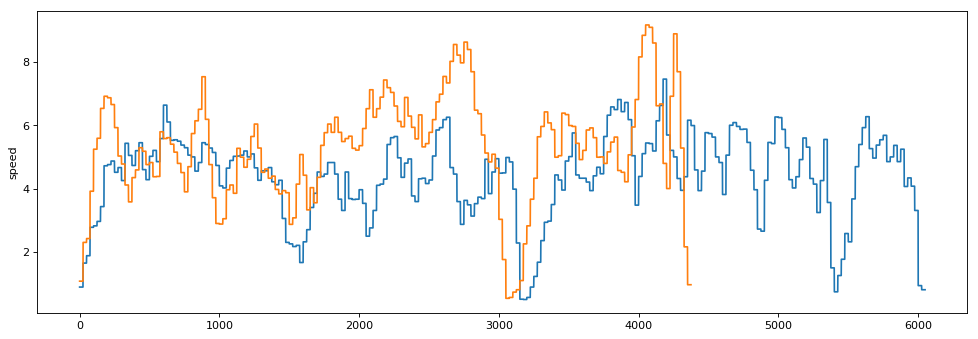

In [9]:
figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(speed)
plt.plot(speed_2)
plt.ylabel('speed')

Text(0, 0.5, 'Altitude')

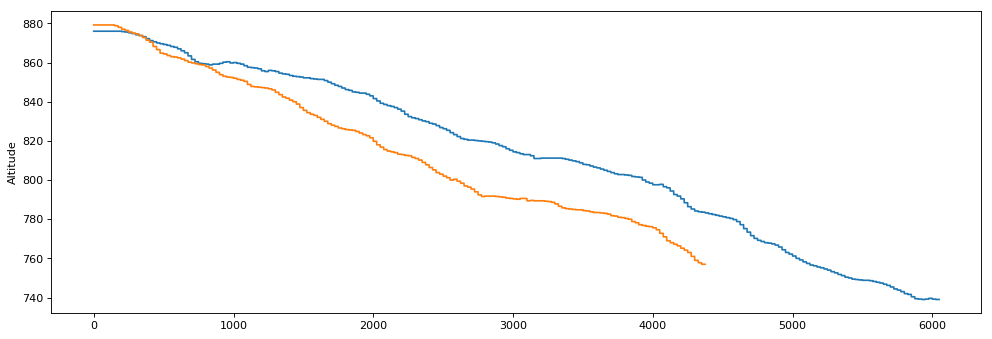

In [10]:
figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(altitude)
plt.plot(altitude_2)
plt.ylabel('Altitude')

Text(0, 0.5, 'Heading')

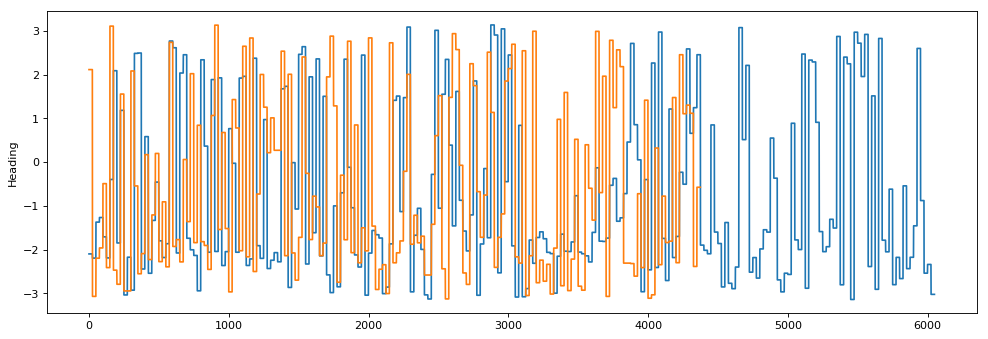

In [11]:
figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(sensor_heading)
plt.plot(sensor_heading_2)
plt.ylabel('Heading')

Text(0, 0.5, 'Heart Rate')

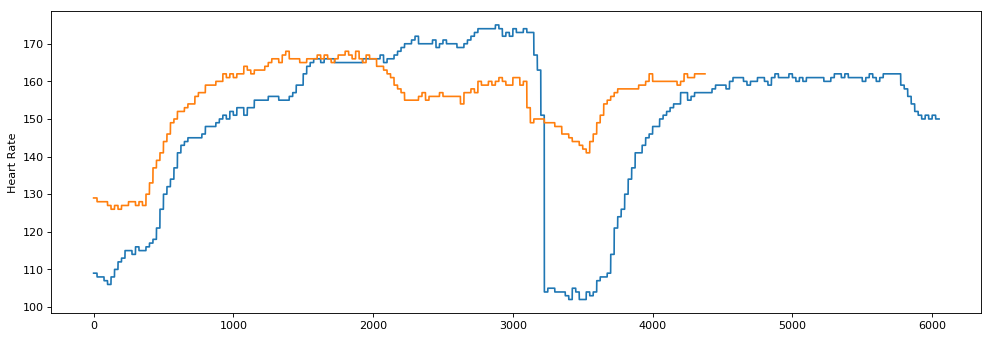

In [12]:
figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(heart_rate)
plt.plot(heart_rate_2)
plt.ylabel('Heart Rate')

Text(0, 0.5, 'Acceleration')

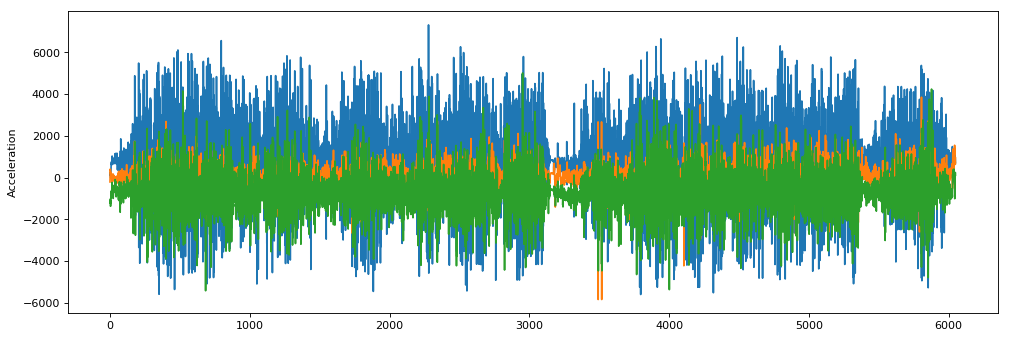

In [13]:
figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(accX_HD)
plt.plot(accY_HD)
plt.plot(accZ_HD)
plt.ylabel('Acceleration 1')

Text(0, 0.5, 'Acceleration 2')

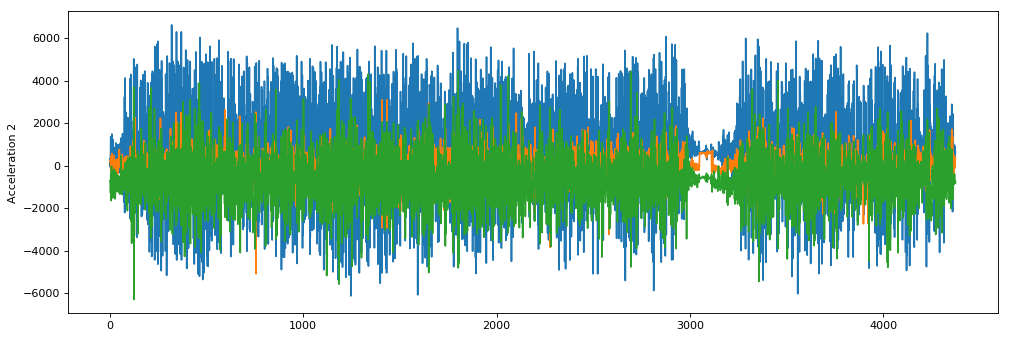

In [14]:
figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(accX_HD_2)
plt.plot(accY_HD_2)
plt.plot(accZ_HD_2)
plt.ylabel('Acceleration 2')